In [1]:
import os
if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)
from src.data.datasets import FreeViewInMemory
import numpy as np
import matplotlib.pyplot as plt


In [2]:
PathDataset = FreeViewInMemory()

In [3]:
durations = []
for i in range(len(PathDataset)):
    durations.append(PathDataset[i][1][2])
durations = np.concat(durations)

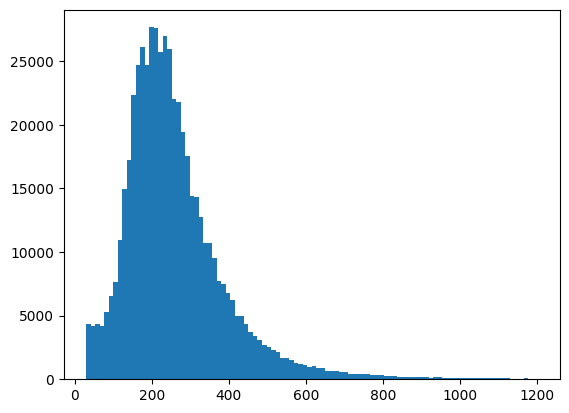

In [4]:
plt.hist(durations, bins=100)
plt.show()


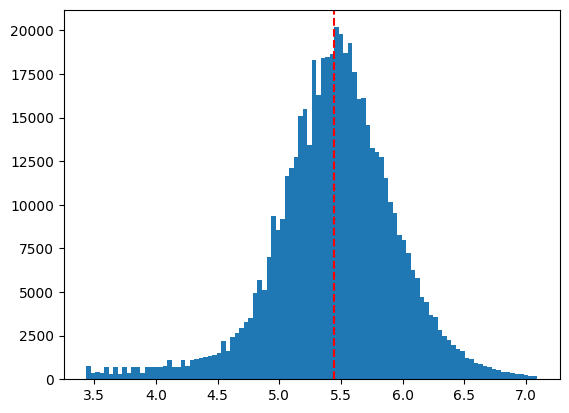

In [5]:
log_durations = np.log1p(durations)
plt.hist(log_durations, bins=100)
# plot mean
plt.axvline(log_durations.mean(), color='red', linestyle='--', label='Mean')
plt.show()

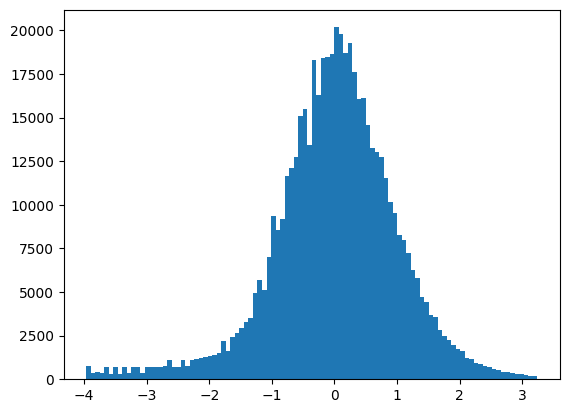

In [6]:
d_mean = log_durations.mean()
d_std = log_durations.std()


z_scores = (log_durations - log_durations.mean()) / log_durations.std()

plt.hist(z_scores, bins=100)
plt.show()


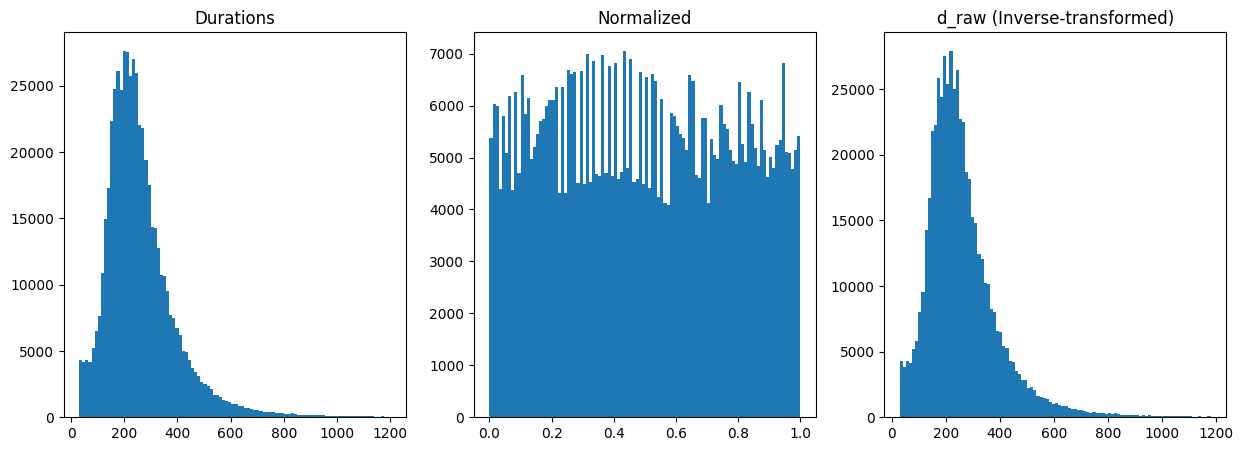

In [7]:
from sklearn.preprocessing import QuantileTransformer
import joblib

# Prepare your data (reshape for sklearn)
durations_reshaped = durations.reshape(-1, 1)

# Initialize Transformer
# output_distribution='uniform' is the key!
qt = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=0)

# Fit and Transform
durations_normalized = qt.fit_transform(durations_reshaped)
d_raw = qt.inverse_transform(durations_normalized)
# Save the transformer for inference later
joblib.dump(qt, 'quantile_transformer.pkl')


fig, axis = plt.subplots(1, 3, figsize=(15, 5))
axis[0].hist(durations, bins=100)
axis[0].set_title('Durations')
axis[1].hist(durations_normalized, bins=100)
axis[1].set_title('Normalized')
axis[2].hist(d_raw, bins=100)
axis[2].set_title('d_raw (Inverse-transformed)')
plt.show()

Are x_inv and z_scores_inv (np.tan inversion) numerically equivalent? True


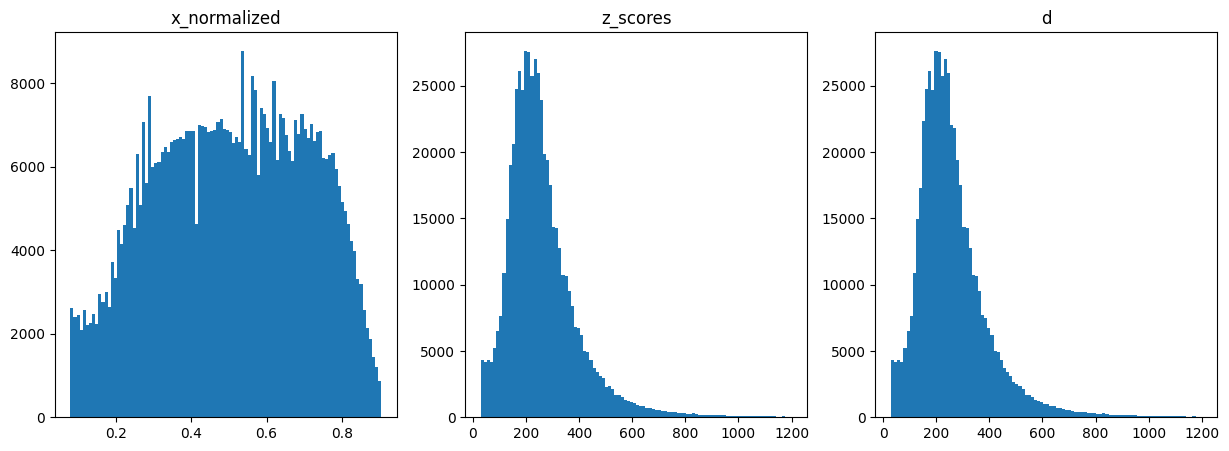

In [23]:
import torch

log_durations = np.log1p(durations)
d_mean = log_durations.mean()
d_std = log_durations.std()


z_scores = (log_durations - log_durations.mean()) / log_durations.std()
x_normalized = (1 / np.pi) * np.arctan(z_scores) + 0.5
#x_inv = np.tan(np.pi*(x_normalized - 0.5))

def recover_durations(normalized):
      d = torch.tan(torch.pi*(torch.from_numpy(normalized) - 0.5))
      return (torch.exp((d*d_std) + d_mean) - 1).numpy()

recovered_durations = recover_durations(x_normalized)
# Compare x_inv computed manually with the expected result from np.arctan and np.tan inverses

# Compute the expected z_scores back from x_normalized using the numpy inverse of the normalization
# Check equivalence with x_inv (already computed above)
print("Are x_inv and z_scores_inv (np.tan inversion) numerically equivalent?",
      np.allclose(d, z_scores, atol=1e-8))


fig, axis = plt.subplots(1,3, figsize=(15,5))
axis[0].hist(x_normalized, bins=100)
axis[0].set_title('x_normalized')
axis[1].hist(recovered_durations, bins=100)
axis[1].set_title('z_scores')
axis[2].hist(durations, bins=100)
axis[2].set_title('d')
plt.show()


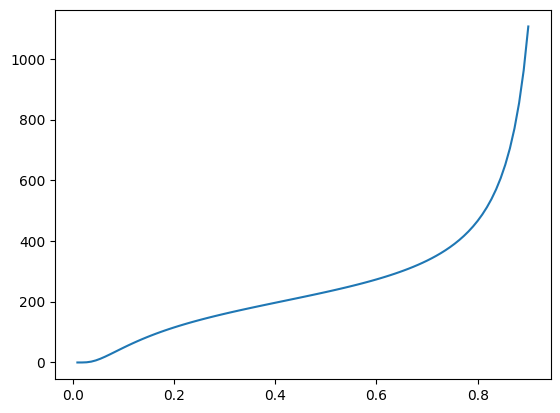

In [28]:
d_test = torch.linspace(0,0.9,100)
almost = torch.tan(torch.pi*(d_test - 0.5))
testing_d = (torch.exp((almost*d_std) + d_mean) - 1)
plt.plot(d_test, testing_d)
plt.show()

In [22]:
(torch.exp((torch.asarray(0.0001)*d_std) + d_mean) - 1)

tensor(231.3282)

In [10]:
print(log_durations.mean())
print(log_durations.std())

print((z_scores < -1.5).sum()/len(z_scores))
print((z_scores < -2.5).sum()/len(z_scores))
print((z_scores > 1.5).sum()/len(z_scores))
print((z_scores > 2.5).sum()/len(z_scores))

5.44810063342112
0.507648587513406
0.06071945326647799
0.022686529133944252
0.05444220986631965
0.006799588675845626


(512, 1664)


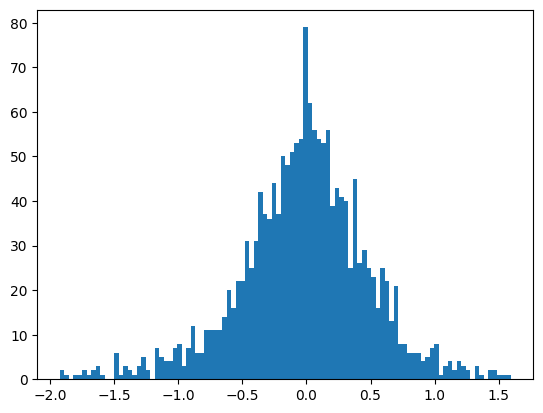

0.13221153846153846
0.0390625
0.0018028846153846155
0.0
0.0


In [11]:
temp = np.random.choice(z_scores/2, size=13*128, replace=True)
normal = np.random.standard_normal(512)
test = temp[None,:]*normal[:,None]
print(test.shape)
to_plot = temp.flatten()
plt.hist(to_plot, bins=100)
plt.show()
per1 = np.sum((test > 1).reshape(test.shape), axis = 0)/test.shape[0]
per2 = np.sum((test < -1).reshape(test.shape), axis = 0)/test.shape[0]
per = per1 + per2
print((per > 0.2).sum()/len(per))
print((per > 0.4).sum()/len(per))
print((per > 0.6).sum()/len(per))
print((per > 0.7).sum()/len(per))
print((per > 0.8).sum()/len(per))

In [12]:
import numpy as np
from scipy.stats import normaltest

statistic, p_value = normaltest(log_durations)

alpha = 0.05

print(f"Test Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significance Level (alpha): {alpha}")

if p_value > alpha:
    print("\nConclusion: Fail to reject the Null Hypothesis (H0). The data appears to be normally distributed.")
else:
    print("\nConclusion: Reject the Null Hypothesis (H0). The data does not appear to be normally distributed.")

Test Statistic: 40793.2029
P-value: 0.0000
Significance Level (alpha): 0.05

Conclusion: Reject the Null Hypothesis (H0). The data does not appear to be normally distributed.


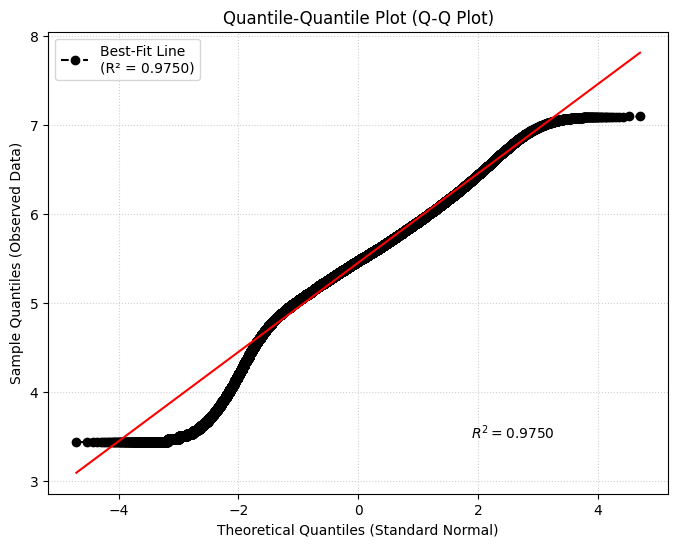

Squared Correlation Coefficient (R²): 0.9750


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot # We use the core SciPy function here

# --- 1. Define or Generate the Data ---


# --- 2. Generate the Q-Q Plot using scipy.stats.probplot ---
fig, ax = plt.subplots(figsize=(8, 6))

# Correct Unpacking: probplot returns (osm, (slope, intercept, r))
(osm, (slope, intercept, r)) = probplot(
    log_durations, 
    dist="norm", 
    plot=ax,
    rvalue=True # Calculate and include the correlation coefficient (r)
) 

# --- 3. Customization (No change needed here) ---
ax.set_title("Quantile-Quantile Plot (Q-Q Plot)")
ax.set_xlabel("Theoretical Quantiles (Standard Normal)")
ax.set_ylabel("Sample Quantiles (Observed Data)")

# The rest of your customization code will work as intended...
line = ax.get_lines()[0]
line.set_color('black')
line.set_linestyle('--')
line.set_label(f'Best-Fit Line\n(R² = {r**2:.4f})')

ax.grid(True, linestyle=':', alpha=0.6)
ax.legend()
plt.show()

print(f"Squared Correlation Coefficient (R²): {r**2:.4f}")

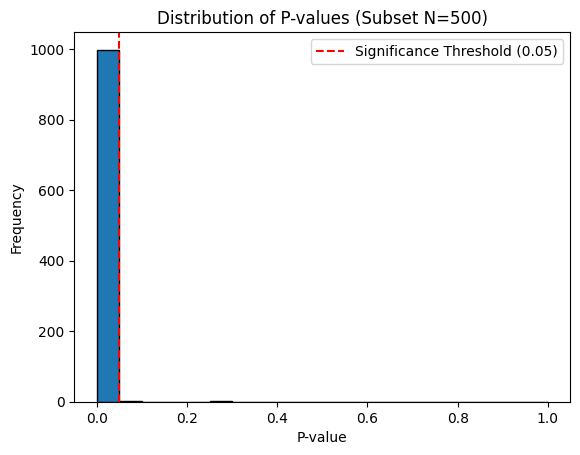

Mean P-value: 0.0005
Percentage of subsets passing normality (>0.05): 0.2%


In [14]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Assume 'durations_log' is your transformed data (500k samples)
subset_size = 500  # A reasonable size for normality testing
num_trials = 1000
p_values = []

for _ in range(num_trials):
    # Take a random subset
    subset = np.random.choice(log_durations, size=subset_size, replace=False)
    stat, p = stats.normaltest(subset)
    p_values.append(p)

# Plotting the result
plt.hist(p_values, bins=20, range=(0, 1), edgecolor='black')
plt.axvline(x=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title(f"Distribution of P-values (Subset N={subset_size})")
plt.xlabel("P-value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Mean P-value: {np.mean(p_values):.4f}")
print(f"Percentage of subsets passing normality (>0.05): {np.mean(np.array(p_values) > 0.05)*100:.1f}%")

## Mixture of guassian

In [40]:
import numpy as np
from sklearn.mixture import GaussianMixture

def fit_and_process_durations(all_durations):
    """
    Fits a GMM (EM algorithm) to durations and generates training targets.
    
    Args:
        all_durations (np.array): Array of all duration values. Shape (N, 1) or (N,)
        
    Returns:
        model_params (dict): The sorted means and stds for the two distributions.
        training_data (dict): The calculated 'class_labels' and 'z_scores' for training.
    """
    # Reshape for sklearn if necessary
    X = all_durations.reshape(-1, 1)

    # 1. EM Algorithm: Fit the Mixture of Gaussians (K=2)
    # n_init=10 runs it 10 times and keeps the best result to avoid local optima
    gmm = GaussianMixture(n_components=2, covariance_type='diag', n_init=10, random_state=42)
    gmm.fit(X)

    # 2. Extract and Sort Parameters
    # We sort by mean so that Index 0 is always the "Short/First" distribution
    # and Index 1 is always the "Long/Second" distribution.
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    
    # Get indices that would sort the means
    idx = np.argsort(means)
    
    sorted_means = means[idx]
    sorted_stds = np.sqrt(variances[idx])
    sorted_weights = gmm.weights_[idx]

    print(f"Distribution 0 (Short): Mean={sorted_means[0]:.4f}, Std={sorted_stds[0]:.4f}")
    print(f"Distribution 1 (Long) : Mean={sorted_means[1]:.4f}, Std={sorted_stds[1]:.4f}")

    # 3. Generate Training Targets
    
    # Get the probability of each component for every data point
    # shape: (N, 2)
    probs = gmm.predict_proba(X)
    
    # Reorder probabilities to match our sorted indices
    probs = probs[:, idx]
    
    # A. Classification Target (Binary)
    # 0 if prob(class 0) > prob(class 1), else 1
    class_labels = np.argmax(probs, axis=1)

    # B. Z-Score Target
    # We need to normalize based on the assigned class's mean/std
    z_scores = np.zeros_like(all_durations, dtype=float)
    
    for i in range(len(all_durations)):
        c = class_labels[i] # The assigned class (0 or 1)
        mu = sorted_means[c]
        sigma = sorted_stds[c]
        
        # Calculate z-score: (x - mu) / sigma
        z_scores[i] = (all_durations[i] - mu) / sigma

    return {
        "means": sorted_means, 
        "stds": sorted_stds, 
        "weights": sorted_weights
    }, {
        "class_labels": class_labels,
        "z_scores": z_scores
    }

# --- Usage Example ---

params, targets = fit_and_process_durations(durations)

# 3. Inspect a few samples
print("\n--- Sample Training Data ---")
for i in [0, 1001]: # Check one from the start and one from the middle
    d = durations[i]
    c = targets['class_labels'][i]
    z = targets['z_scores'][i]
    print(f"Raw Duration: {d:.4f} -> Target Class: {c}, Target Z-Score: {z:.4f}")

Distribution 0 (Short): Mean=220.9059, Std=79.1235
Distribution 1 (Long) : Mean=419.1773, Std=182.9019

--- Sample Training Data ---
Raw Duration: 316.0000 -> Target Class: 0, Target Z-Score: 1.2018
Raw Duration: 181.0000 -> Target Class: 0, Target Z-Score: -0.5043


<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ulloa\AppData\Local\Temp\ipykernel_34524\3813846787.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x1, y1, label=f'Gaussian ($\mu$={mu1}, $\sigma$={sigma1})')
C:\Users\ulloa\AppData\Local\Temp\ipykernel_34524\3813846787.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x1, y1, label=f'Gaussian ($\mu$={mu1}, $\sigma$={sigma1})')
C:\Users\ulloa\AppData\Local\Temp\ipykernel_34524\3813846787.py:21: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x2, y2, label=f'Gaussian ($\mu$={mu2}, $\sigma$={sigma2})')
C:\Users\ulloa\AppData\Local\Temp\ipykernel

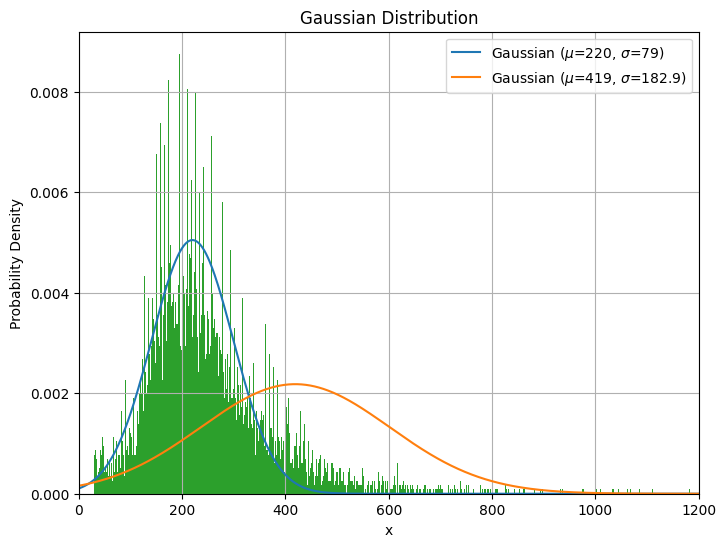

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Example: plot a Gaussian curve
def gen_gaussian(mu, sigma, x = None):
    if x is None:
        x = np.linspace(0,1200, 1000)
    y = (1/(np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu)/sigma)**2)
    return x, y

mu1 = 220
sigma1 = 79
mu2 = 419
sigma2 = 182.9
x1,y1 = gen_gaussian(mu1,sigma1)
x2,y2 = gen_gaussian(mu2, sigma2)
x = np.linspace(0,1200, 1000)

plt.figure(figsize=(8, 6))
plt.plot(x1, y1, label=f'Gaussian ($\mu$={mu1}, $\sigma$={sigma1})')
plt.plot(x2, y2, label=f'Gaussian ($\mu$={mu2}, $\sigma$={sigma2})')
plt.hist(durations[:10000],1000, density = True)
plt.xlim(0,1200)
plt.title('Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


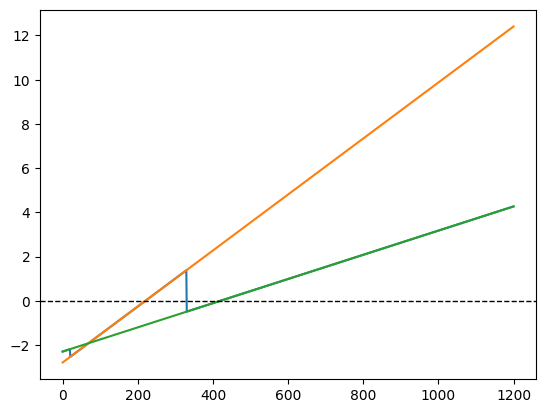

In [56]:
def normalize(x,m,s):
    return (x - m)/s

first_dist = y1 > y2
second_dist = y2 > y1
first_score = normalize(x, mu1, sigma1)
second_score = normalize(x, mu2, sigma2)
scores = x.copy()
scores[first_dist] = first_score[first_dist]
scores[second_dist] = second_score[second_dist]
plt.plot(x, scores)
plt.plot(x, first_score)
plt.plot(x, second_score)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()
    

In [54]:
_, prob1 = gen_gaussian(mu1,sigma1, durations)
_, prob2 = gen_gaussian(mu2,sigma2, durations)
first = sum(prob1 > prob2)
print(first)
print(durations.shape - first)

428337
[121108]


AttributeError: 'tuple' object has no attribute 'shape'